In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

load a lookup table

In [3]:
psr = 'J2214+3000'

## just a quick concatenation of the two files
## currently, they're produced in parallel so there's one for negative-signed, one is positive-signed
neg_signs_file = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1855+09/B1855+09_-1.txt'
pos_signs_file = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1855+09/B1855+09_1.txt'

combined_table = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1855+09/B1855+09_lookup.txt'

filenames = [neg_signs_file, pos_signs_file]
with open(combined_table, 'w+') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [4]:
lfile = os.path.join('/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/', psr, '{:}_lookup.txt'.format(psr))
pfile = os.path.join('/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/', psr, 'pars.txt')

lookup = np.loadtxt(lfile)
params = np.loadtxt(pfile, dtype=str)

In [5]:
print(params)

# N grid pts for each param
Ngrid = [70, 80, 80, 100, 2]  # gamma, A_RN, A_BWM, t0

['B1855+09_red_noise_gamma;0,7,70' 'B1855+09_red_noise_log10_A;-18,-12,60'
 'ramp_log10_A;-18,-12,60' 'ramp_t0;53448.0,57265.0,100' 'sign;-1,1,2']


## get grid points

The grid is set up by doing this:
```
gammas = np.linspace(0, 7, 70, endpoint=True) #grid points for gamma
log10_rn_amps = np.linspace(-20, -12, 80, endpoint=True) #grid points for the pulsar red noise
log10_burst_amplitudes = np.linspace(-20, -12, 80, endpoint=True) #grid points for the burst strain
Ts = np.linspace(t0min, t0max, num=100, endpoint=True)
```

This should pull the actual lists from the table:

In [ ]:
RN_gams = lookup[:70, 0]
RN_amps = lookup[:70*60:70, 1]
BWM_amps = lookup[:70*60*60:70*50, 2]
BWM_t0s = lookup[:70*60*60*100:70*60*60, 3]
BWM_signs = lookup[:70*60*60*100*2:0*60*60*100, 4]

In [6]:
RN_gams = np.linspace(0, 7, 70, endpoint=True)
RN_amps = np.linspace(-18, -12, 60, endpoint=True)
BWM_amps = np.linspace(-18, -12, 60, endpoint=True)
BWM_t0s = np.linspace(53448.0,57265.0,100, endpoint=True)
BWM_signs = np.linspace(-1,1,2, endpoint=True)

The table differs by roundoff from recomputing it, but otherwise these seem ok...

In [ ]:
len(RN_gams), len(RN_amps), len(BWM_amps), len(BWM_t0s)

In [ ]:
RN_gams - np.linspace(0, 7, 70, endpoint=True)

In [ ]:
RN_amps - BWM_amps

In [ ]:
BWM_t0s

In [7]:
print(70*60*60*100*2, len(lookup))

50400000 50400000


## get logL

The logL is a 4D surface.  To plot 2D slices we need to reshape the 1D list to the correct shape.

To compare to previous runs we need to marginalize over the other parameters not just take a slice.  Since the grid is even, just summing over the nuisance indices should do the trick.

This logL isn't normalized, so we'll rescale it to min=0 to make the numbers more human friendly

In [8]:
# reshape logL to 4D grid
#logL = lookup[:,4].reshape(Ngrid)

# logL ording is different than I expected... This seems to be the right order

logL = lookup[:].reshape((2,100,60,60,70))
#this corresponds to [sign, burst_t0, burst_amp, rn_amp, rn_gamma]
logL -= np.min(logL)

## 1D marginalized logL

lets get some 1D slices... these are not normalized, but that doesn't matter just yet

In [9]:
# this was the order I expected
#logL_RNgam = np.sum(logL, axis=(1,2,3))
#logL_RNamp = np.sum(logL, axis=(0,2,3))
#logL_BWMamp = np.sum(logL, axis=(0,1,3))
#logL_BWMt0 = np.sum(logL, axis=(0,1,2))

# this seems to be the right order
logL_RNgam = np.sum(logL, axis=(0,1,2,3))
logL_RNamp = np.sum(logL, axis=(0,1,2,4))
logL_BWMamp = np.sum(logL, axis=(0,1,3,4))
logL_BWMt0 = np.sum(logL, axis=(0,2,3,4))
logL_BWMsign = np.sum(logL, axis=(1,2,3,4))

still the right shape!

In [10]:
len(logL_RNgam), len(logL_RNamp), len(logL_BWMamp), len(logL_BWMt0), len(logL_BWMsign)

(70, 60, 60, 100, 2)

No handles with labels found to put in legend.


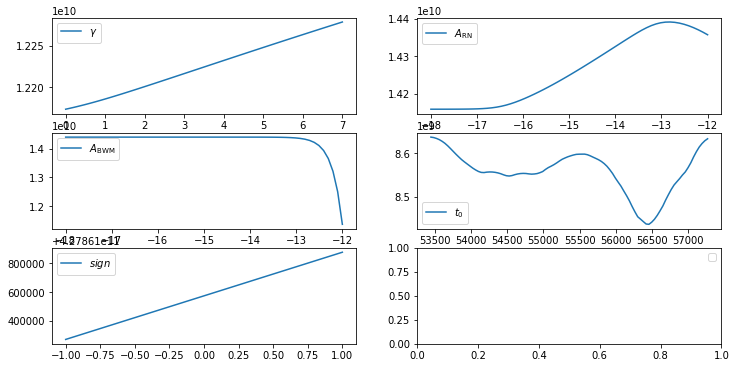

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
ax[0,0].plot(RN_gams, logL_RNgam, label=r'$\gamma$')
ax[0,1].plot(RN_amps, logL_RNamp, label=r'$A_\mathrm{RN}$')
ax[1,0].plot(BWM_amps, logL_BWMamp, label=r'$A_\mathrm{BWM}$')
ax[1,1].plot(BWM_t0s, logL_BWMt0, label=r'$t_0$')
ax[2,0].plot(BWM_signs, logL_BWMsign, label='$sign$')
for a in ax.flatten():
    a.legend()

## 2D marginalized logL

In [ ]:
# "marginalize" over burst params
logL_RN = np.sum(logL, axis=(0,1,2))
logL_RN.shape

In [ ]:
plt.contourf(RN_gams, RN_amps, logL_RN, cmap='Blues')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$A_\mathrm{RN}$')

In [ ]:
# "marginalize" over RN params
logL_BWM = np.sum(logL, axis=(0,3,4))
logL_BWM.shape

In [ ]:
plt.contourf(BWM_t0s, RN_amps, logL_BWM.T, cmap='Blues')
plt.xlabel(r'$t_0$')
plt.ylabel(r'$A_\mathrm{BWM}$')

In [ ]:
sign = -0.5
sign(sign)